In [1]:
%run C:/Users/HSS/dd.py

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
card = data.copy()

In [14]:
card.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

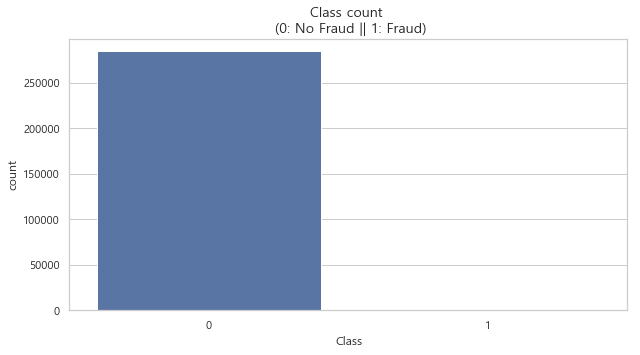

In [18]:
plt.figure(figsize = (10,5))
sns.countplot(card.Class)
plt.title('Class count \n (0: No Fraud || 1: Fraud)', fontsize =14)
plt.show()

In [7]:
x = card.iloc[:,1:-1]
y= card.iloc[:,-1]
print(x.shape, y.shape)

(284807, 29) (284807,)


### 데이터 분리

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13, stratify= y)

In [36]:
#17%가 아니라 0.17%
round(\
np.unique(y_train, return_counts = True)[1][1]/len(y_train)*100,2)

0.17

### 일단 돌려

In [45]:
from sklearn.metrics import *
import time


# 성능을 반환하는 함수
def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

# 성능을 출력하는 함수


def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
#     start = time.time()
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print('=> confusion matrix')
    print(confusion)
    print('='*10)
#     print('Time : {}'.format(time.time() - start))

    print('Accuracy : {}, Precision: {}'.format(acc, pre))
    print('Recall: {}, F1: {}, AUC: {}'.format(re, f1, auc))

In [64]:
### Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_clf = LogisticRegression(random_state = 13, solver = 'liblinear')
lr_clf.fit(x_train, y_train)
preds = model.predict(x_test)

print_clf_eval(y_test, preds)

=> confusion matrix
[[85284    11]
 [   60    88]]
Time : 0.056966304779052734
Accuracy : 0.99916903666772, Precision: 0.8888888888888888
Recall: 0.5945945945945946, F1: 0.7125506072874493, AUC: 0.7972328152057329


In [60]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state = 13, max_depth = 4)
dt_clf.fit(x_train, y_train)
preds = dt_clf.predict(x_test)

print_clf_eval(y_test, preds)

=> confusion matrix
[[85281    14]
 [   42   106]]
Time : 0.16042685508728027
Accuracy : 0.9993445923013002, Precision: 0.8833333333333333
Recall: 0.7162162162162162, F1: 0.791044776119403, AUC: 0.8580260399915715


In [61]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 13, n_jobs = 1, n_estimators = 100)
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_test)

print_clf_eval(y_test, rf_pred)

=> confusion matrix
[[85290     5]
 [   38   110]]
Time : 0.06696271896362305
Accuracy : 0.9994967405170698, Precision: 0.9565217391304348
Recall: 0.7432432432432432, F1: 0.8365019011406843, AUC: 0.8715923115800014


In [62]:
### LightGBM
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
lgbm_clf.fit(x_train, y_train)
lgbm_pred = lgbm_clf.predict(x_test)

print_clf_eval(y_test, lgbm_pred)

=> confusion matrix
[[85288     7]
 [   35   113]]
Time : 0.08295035362243652
Accuracy : 0.9995084442259752, Precision: 0.9416666666666667
Recall: 0.7635135135135135, F1: 0.8432835820895522, AUC: 0.8817157226984883


In [63]:
#모델과 성능을 나타내는 함수
def get_result(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    return get_clf_eval(y_test, pred)

#다수의 모델의 성능을 정리해 데이터 프레임화하는 함수
def get_result_pd(models, model_names, x_train, y_train, x_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []
    
    for model in models:
        tmp.append(get_result(model, x_train, y_train, x_test, y_test))
    return pd.DataFrame(tmp, columns = col_names, index = model_names)



In [65]:
### 4개이 분류 모델 성능 정리

import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LinearReg', 'DecisionTree', 'RandomForest', 'LightGBM']
start = time.time()
results = get_result_pd(models, model_names, x_train, y_train, x_test, y_test)

print('Fit time: ', time.time() - start)
results

Fit time:  277.1049244403839


,accuracy,precision,recall,f1,roc_auc
LinearReg,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999508,0.941667,0.763514,0.843284,0.881716


In [66]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### 전처리 좀 하고 해보자

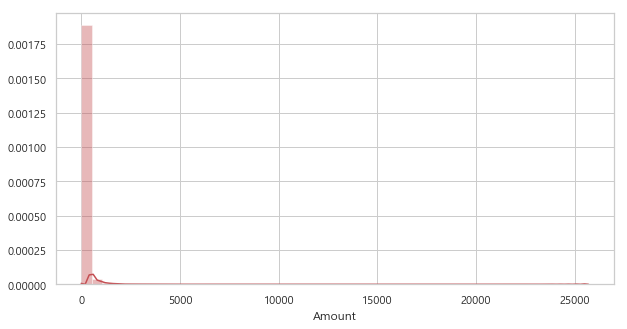

In [69]:
plt.figure(figsize = (10,5))
sns.distplot(data.Amount, color = 'r')
plt.show()

In [71]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
amount_n = scaler.fit_transform(card['Amount'].values.reshape(-1,1))


In [72]:
card = card.iloc[:,1:-2]
card['Amount_scaled'] = amount_n
card.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [75]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13, stratify = y)

In [11]:

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LinearReg', 'DecisionTree', 'RandomForest', 'LightGBM']
start = time.time()
results = get_result_pd(models, model_names, x_train, y_train, x_test, y_test)

print('Fit time: ', time.time() - start)
results

NameError: name 'lr_clf' is not defined

In [80]:
### 모델별 ROC 커브

from sklearn.metrics import roc_curve

def draw_roc_curve(models, model_names, x_test, y_test):
    plt.figure(figsize = (10,10))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(x_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test,pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1],[0,1], 'k--', label = 'random guess')
    plt.title('ROC')
    plt.legend(); plt.grid();
    plt.show()

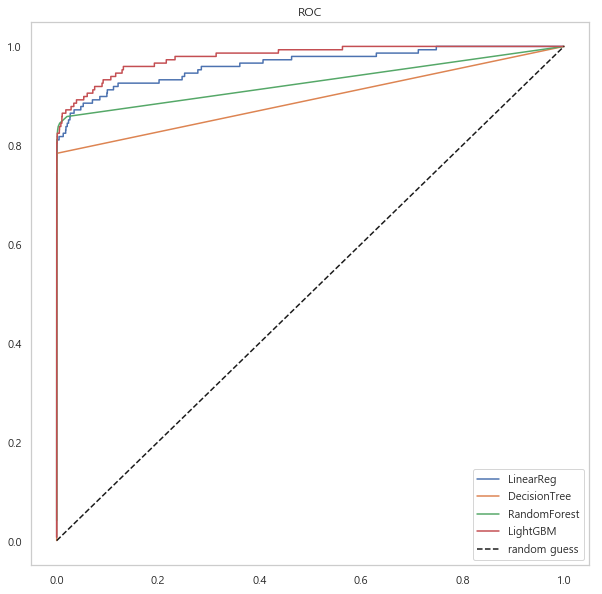

In [81]:
draw_roc_curve(models, model_names, x_test, y_test)

In [86]:
### log scale
amount_log = np.log1p(data['Amount'])
card['Amount_scaled'] = amount_log
card.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539


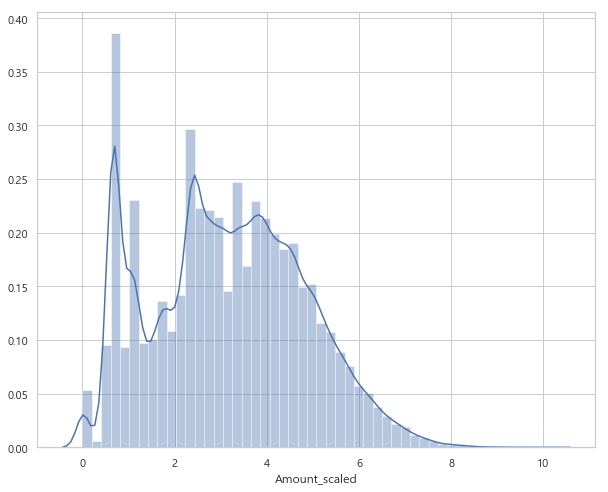

In [89]:
plt.figure(figsize = (10,8))
sns.distplot(card.Amount_scaled)
plt.show()

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13)
start = time.time()

result = get_result_pd(models, model_names, x_train, y_train, x_test, y_test)

print('Fit time: ', time.time() - start)
results

Fit time:  413.3012840747833


,accuracy,precision,recall,f1,roc_auc
LinearReg,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999508,0.941667,0.763514,0.843284,0.881716


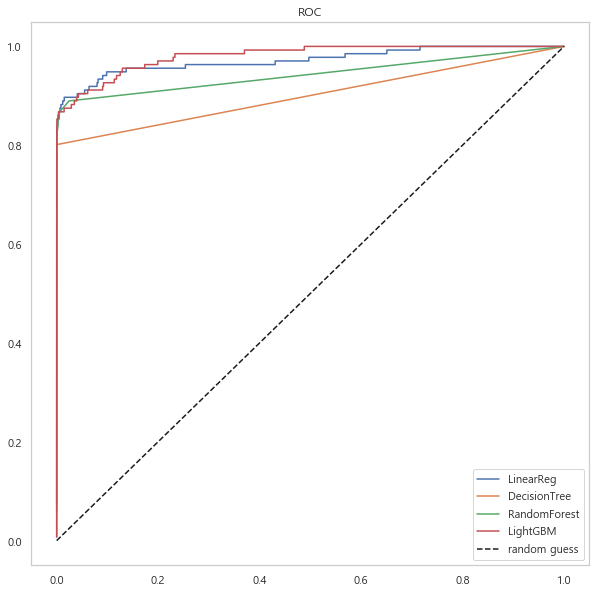

In [92]:
draw_roc_curve(models, model_names, x_test, y_test)

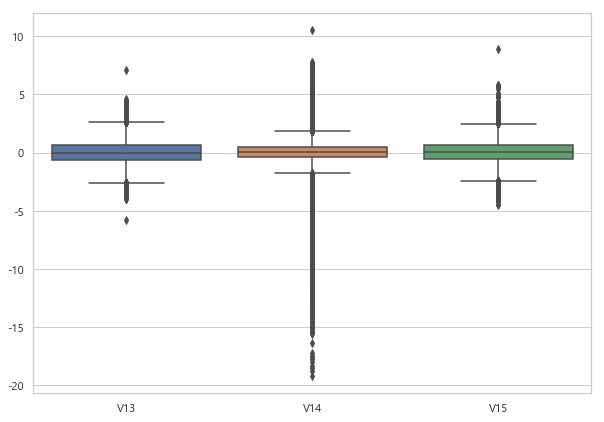

In [94]:
plt.figure(figsize = (10,7))
sns.boxplot(data = card[['V13','V14','V15']])

In [95]:
def get_outlier(df = None, column = None, weight = 1.5):
    fraud = df.query('Class == 1')[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    out_lier_index = fraud[(fraud < lowest_val)| (fraud > highest_val)].index
    
    return out_lier_index

In [99]:
out_lier_index = get_outlier(df = data, column = 'V14', weight = 1.5)
card.drop(out_lier_index, axis = 0, inplace = True)
card.shape


(284803, 29)

In [100]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13, stratify = y)


models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LinearReg', 'DecisionTree', 'RandomForest', 'LightGBM']
start = time.time()
results = get_result_pd(models, model_names, x_train, y_train, x_test, y_test)

print('Fit time: ', time.time() - start)
results

Fit time:  361.327650308609


,accuracy,precision,recall,f1,roc_auc
LinearReg,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999508,0.941667,0.763514,0.843284,0.881716


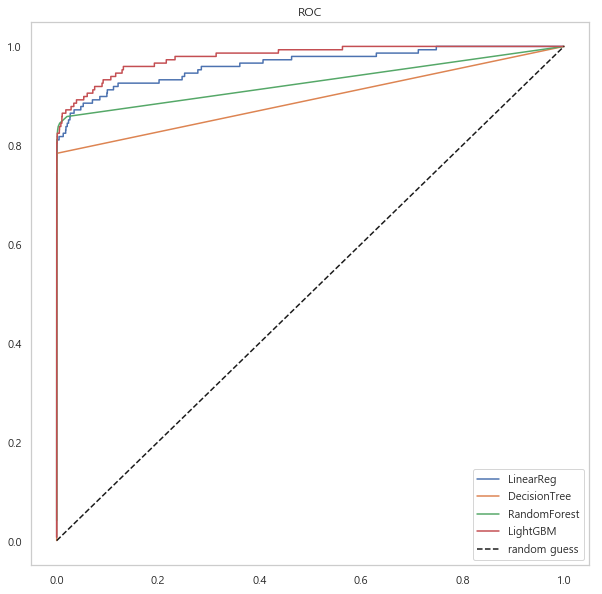

In [101]:
draw_roc_curve(models, model_names, x_test, y_test)

### 데이터 불균형 해결

In [116]:
!pip install imbalanced-learn

You are using pip version 18.0, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13, stratify= y)

smote = SMOTE(random_state = 13)
x_train_over , y_train_over = smote.fit_sample(x_train, y_train)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 13, stratify = y)


models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LinearReg', 'DecisionTree', 'RandomForest', 'LightGBM']
start = time.time()
results = get_result_pd(models, model_names, x_train_over, y_train_over, x_test, y_test)

print('Fit time: ', time.time() - start)
results

NameError: name 'lr_clf' is not defined